# Portfolio-Exam Part I - Sentiment Analysis

* Social Media Analytics - MADS-SMA
* Valentin Werger

In [1]:
# Compare different approaches
# Train own word embedding
# Use model trained on yelp for other data
# Try out sentiments towards types of entities

In [1]:
# Loading required ML packages and functions
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.metrics import roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import os
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim.downloader

In [3]:
# Read Hamburg Yelp reviews
yelp = pd.read_csv("data/yelp_reviews_hamburg_en.csv", parse_dates=["date"])

In [4]:
# Overview of the data
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   url     3025 non-null   object        
 1   stars   3025 non-null   float64       
 2   text    3025 non-null   object        
 3   date    3025 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 94.7+ KB


In [5]:
# Show the top 5 rows
yelp.head(5)

,url,stars,text,date
0,https://www.yelp.com/biz/il-buco-hamburg,5.0,Fantastic little restaurant!Great staff and fo...,2017-08-12
1,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,We went there to grab some breakfast. They are...,2015-09-29
2,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,"Good coffee, sandwiches, and yogurts close t...",2016-01-13
3,https://www.yelp.com/biz/campus-suite-hamburg-7,3.0,When XING handed out coupons for free coffee d...,2008-04-24
4,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,I love Campus Suite franchise. after the Balza...,2010-01-15


In [6]:
# Extract name of the location from url
yelp["name"] = yelp.apply(lambda row: re.sub("https://www.yelp.com/biz/", "", row["url"]), axis=1)
yelp = yelp.drop(columns="url")

<AxesSubplot:ylabel='Count'>

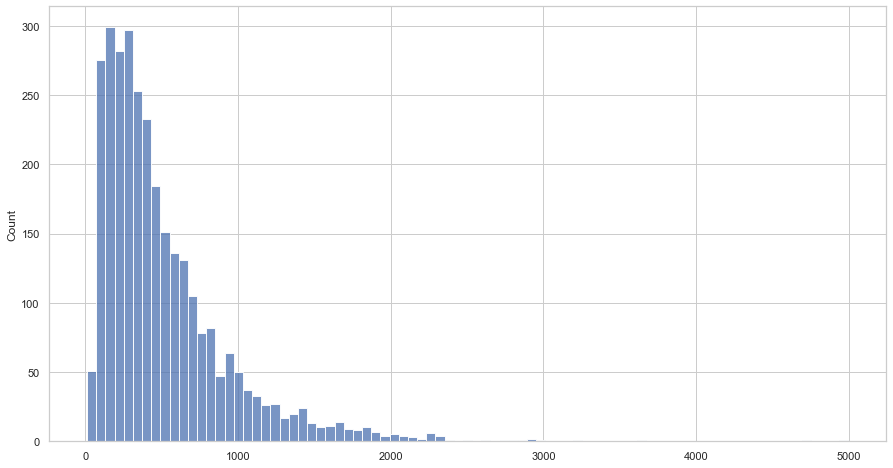

In [7]:
# Inspect length of review text
text_length_distribution = np.array([len(text) for text in yelp.text])

sns.set_theme(style="whitegrid")
plt.figure(figsize=[15,8])
sns.histplot(data = text_length_distribution)

# Problem: Maximum length of Bert is 512


In [11]:
rating_counts

5.0    1359
4.0     974
3.0     395
2.0     157
1.0     140
Name: stars, dtype: int64

<AxesSubplot:xlabel='stars', ylabel='count'>

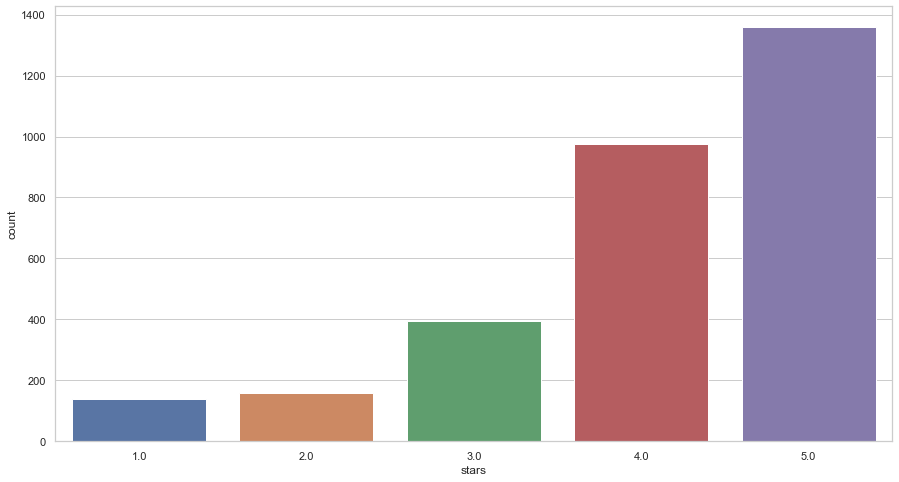

In [20]:
# Check distribution of ratings
sns.set_theme(style="whitegrid")
plt.figure(figsize=[15,8])
sns.countplot(data = yelp, x = "stars")

In [21]:
# Load potential sets of word vectors
#list(gensim.downloader.info()['models'].keys())
potential_wv = {}
print("Downloading glove-wiki-gigaword-50")
potential_wv["wv_glove_wiki"] = gensim.downloader.load('glove-wiki-gigaword-300')
print("Downloading glove-twitter-50")
potential_wv["wv_glove_twitter"] = gensim.downloader.load('glove-twitter-200')
print("Downloading word2vec-google-news-300")
potential_wv["wv_word2vec"] = gensim.downloader.load('word2vec-google-news-300')

In [139]:
# Sentiment Analyser class
class SentimentAnalyser():

    def __init__(self, data, target, normalize = True):
        self.data = data
        self.target = target
        self.target_distribution = self.data[self.target].value_counts(normalize=True)

        # Normalize the review texts
        if normalize:
            self.data["text"] = self.normalize()

        # Initialize container for experiment results
        self.experiment_results = {}
        self.__run = 1

        # Produce word embeddings for the whole dataset
        self.word_embeddings = {}
        for vector_set in ["wv_glove_wiki", "wv_glove_twitter", "wv_word2vec"]:
            self.word_embeddings[vector_set] = self.produce_embeddings(self.data.text, vector_set)

        # Set up experiments to conduct
        self.experiments = [
            {
                'name': 'Logistic Regression',
                'model': LogisticRegression(n_jobs = os.cpu_count() -1, solver="saga", l1_ratio=0.5),
                'params': {
                    'preprocessor': [
                        self.__WordCountTransformerHelper(min_df=1, ngram_range=(1,1), data=self.data),
                        self.__WordCountTransformerHelper(min_df=2, ngram_range=(1,1), data=self.data),
                        self.__WordCountTransformerHelper(min_df=3, ngram_range=(1,1), data=self.data),
                        self.__WordCountTransformerHelper(min_df=1, ngram_range=(1,2), data=self.data),
                        self.__TfidfTransformerHelper(norm="l2", data=self.data),
                        self.__TfidfTransformerHelper(norm="l1", data=self.data),
                        self.__WordEmbeddingHelper(data=self.word_embeddings["wv_glove_wiki"]),
                        self.__WordEmbeddingHelper(data=self.word_embeddings["wv_glove_twitter"]),
                        self.__WordEmbeddingHelper(data=self.word_embeddings["wv_word2vec"]),
                        #FunctionTransformer(self.word_embedding_helper_function, kw_args={'wv':"wv_glove_wiki"}),
                        #FunctionTransformer(self.word_embedding_helper_function, kw_args={'wv':"wv_glove_twitter"}),
                        #FunctionTransformer(self.word_embedding_helper_function, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__penalty': ["none", "l2", "l1", "elasticnet"],
                    'estimator__C': [0.5, 1, 2]
                }
            },
            {
                'name': 'KNeighbors',
                'model': KNeighborsClassifier(algorithm = "auto", n_jobs = os.cpu_count() -1),
                'params': {
                    'preprocessor': [
                        CountVectorizer(min_df=1), 
                        CountVectorizer(min_df=2), 
                        CountVectorizer(min_df=3), 
                        CountVectorizer(ngram_range=(1,2)),
                        TfidfVectorizer(norm='l1'),
                        TfidfVectorizer(norm='l2'),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__n_neighbors': randint(1, 10), 
                    'estimator__weights': ["uniform", "distance"], 
                    'estimator__metric': ["euclidean", "manhattan"]
                }
            },
            {
                'name': 'Random Forest',
                'model': RandomForestClassifier(n_jobs = os.cpu_count() -1, verbose = 1, random_state = 33),
                'params': {
                    'preprocessor': [
                        CountVectorizer(min_df=1), 
                        CountVectorizer(min_df=2), 
                        CountVectorizer(min_df=3), 
                        CountVectorizer(ngram_range=(1,2)),
                        TfidfVectorizer(norm='l1'),
                        TfidfVectorizer(norm='l2'),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__criterion': ['gini', 'entropy'],
                    'estimator__n_estimators': randint(1, 100), 
                    'estimator__max_features': uniform(0.1,0.9),
                    'estimator__class_weight': [None, 'balanced', 'balanced_subsample'],
                    'estimator__ccp_alpha': uniform(0,0.1)
                }
            },
            {
                'name': 'SVM',
                'model': SVC(verbose = True, random_state = 33),
                'params': {
                    'preprocessor': [
                        CountVectorizer(min_df=1), 
                        CountVectorizer(min_df=2), 
                        CountVectorizer(min_df=3), 
                        CountVectorizer(ngram_range=(1,2)),
                        TfidfVectorizer(norm='l1'),
                        TfidfVectorizer(norm='l2'),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__C': uniform(0.001, 1),
                    'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                    'estimator__degree': randint(1, 5),
                    'estimator__gamma': uniform(0.0001, 1),
                    'estimator__class_weight': [None, 'balanced']
                }
            },
            # When in doubt use XGBoost
            {
                'name': 'XGBoost',
                'model': XGBClassifier(
                    objective = "multi:softprob",
                    num_class = 5, 
                    tree_method = "auto",
                    eval_metric = "auc", 
                    verbosity = 1,
                    use_label_encoder = False,
                    random_state = 33),
                'params': {
                    'preprocessor': [
                        CountVectorizer(min_df=1), 
                        CountVectorizer(min_df=2), 
                        CountVectorizer(min_df=3), 
                        CountVectorizer(ngram_range=(1,2)),
                        TfidfVectorizer(norm='l1'),
                        TfidfVectorizer(norm='l2'),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_wiki"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_glove_twitter"}),
                        FunctionTransformer(self.produce_embeddings, kw_args={'wv':"wv_word2vec"})
                        ],
                    'oversampler': ['passthrough', SMOTE(random_state=33)],
                    'estimator__learning_rate': uniform(0.001, 0.5),
                    'estimator__gamma': uniform(0, 0.5),
                    'estimator__max_depth': randint(3, 10),
                    'estimator__colsample_bytree': uniform(0.5, 0.5)
                }
            }
        ]

    def __normalize_document(self, doc, tokenizer, stop_words):
        doc = re.sub(r'@[\w]+', '', doc)          # replace user mentions
        doc = re.sub(r'http[\S]+', 'URL', doc)    # replace URLs
        doc = re.sub(r'[^\w\s]', '', doc)         # keep words and spaces
        doc = doc.lower()
        doc = doc.strip()
        tokens = tokenizer.tokenize(doc)
        filtered_tokens = [token for token in tokens if token not in stop_words]
        doc = ' '.join(filtered_tokens)
        return doc

    def normalize(self):
        stop_words = nltk.corpus.stopwords.words('english')
        wpt = nltk.WordPunctTokenizer()

        return self.data.text.apply(lambda x: self.__normalize_document(x, wpt, stop_words))

    def naive_baseline(self):
        self.data["naive_baseline_prediction"] = np.random.choice(self.target_distribution.index.to_numpy(), size = len(self.data), replace = True, p = self.target_distribution.values)

    def vader_sentiment(self):
        vader = SentimentIntensityAnalyzer()
        self.data['vader_scores'] = self.data.text.apply(lambda x: vader.polarity_scores(x))
        self.data['vader_compound'] = self.data.vader_scores.apply(lambda x: x['compound'])
        self.data['vader_prediction'] = self.data.vader_compound.apply(lambda x: 1 if x >= 0 else 0)
        pd.crosstab(self.data[self.target], self.data.vader_prediction, normalize='all')

    def textblob_sentiment(self):
        self.data['textblob_score'] = self.data.text.apply(
            lambda review: TextBlob(review).sentiment[0])
        self.data['textblob_prediction'] = self.data.textblob_score.apply(lambda x: 1 if x >= 0 else 0)
        pd.crosstab(self.data[self.target], self.data.textblob_prediction, normalize='all')

    def produce_embeddings(self, X, wv):
        print(f"Produce word embeddings for - {wv}")

        vocabulary = set(potential_wv[wv].index_to_key)
        wpt = nltk.WordPunctTokenizer()

        def avg_embeddings(document):
            words = wpt.tokenize(document)
            invocab = [word for word in words if word in vocabulary]
            avg = np.mean(potential_wv[wv][invocab], axis=0) if len(invocab) >= 1 else []
            return avg

        doc_embeddings = np.array([avg_embeddings(doc) for doc in X.values])
        return doc_embeddings

    def word_embedding_helper_function(self, X, wv):
        embedding = self.word_embeddings[wv]
        return embedding[X]

    class __WordEmbeddingHelper(TransformerMixin, BaseEstimator):

        def __init__(self, data):
            self.data = data

        def fit(self, X, y=None):
            return self

        def transform(self, X):
            return self.data[X]

    class __WordCountTransformerHelper(TransformerMixin, BaseEstimator):

        def __init__(self, data, min_df=1, ngram_range=(1,1)):
            self.data = data
            self.min_df = min_df
            self.ngram_range = ngram_range
            self.transformer = CountVectorizer(min_df=self.min_df, ngram_range=self.ngram_range)

        def fit(self, X, y=None):
            self.transformer.fit(self.data.text[X])
            return self

        def transform(self, X):
            return self.transformer.transform(self.data.text[X])

    class __TfidfTransformerHelper(TransformerMixin, BaseEstimator):

        def __init__(self, data, norm="l2"):
            self.data = data
            self.norm = norm
            self.transformer = TfidfVectorizer(norm=self.norm)

        def fit(self, X, y=None):
            self.transformer.fit(self.data.text[X])
            return self

        def transform(self, X):
            return self.transformer.transform(self.data.text[X])


    def evaluate_classifier(self, name, model, params, iterations, cv_splits, cv_repeats):

        class Debug(BaseEstimator, TransformerMixin):

            def transform(self, X):
                # Comment in the following line to print data shape during Pipeline
                #print(X.shape)
                return X

            def fit(self, X, y=None, **fit_params):
                return self

        # The preprocessor set here is just a default and gets overwritten by the possible preprocessors in the parameter space
        pipeline = Pipeline([("debug1", Debug()), ('preprocessor', CountVectorizer()), ("debug2", Debug()), ('oversampler', SMOTE()), ('estimator', model)])

        # Setting up the Cross validation
        inner_cv = RepeatedStratifiedKFold(n_splits = cv_splits, n_repeats = cv_repeats, random_state = 33)
        outer_cv = RepeatedStratifiedKFold(n_splits = cv_splits, n_repeats = cv_repeats, random_state = 33)

        # Doing hyperparameter optimization
        optimization = RandomizedSearchCV(
            estimator = pipeline,
            param_distributions = params,
            scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted', 'roc_auc_ovo_weighted'],
            cv = inner_cv,
            refit = 'roc_auc_ovo_weighted',
            n_iter = iterations,
            n_jobs = os.cpu_count() -1,
            verbose = 1,
            random_state = 33)

        optimization.fit(np.array(range(len(self.data))), self.data[self.target])

        # Evaluating the best model on the outer cross validation
        performance_estimation = cross_validate(
            estimator = optimization,
            X = np.array(range(len(self.data))),
            y = self.data[self.target],
            scoring = ['accuracy', 'balanced_accuracy', 'f1_weighted', 'roc_auc_ovo_weighted'],
            cv = outer_cv,
            n_jobs = os.cpu_count() -1)

        return(
        {
            'name': name,
            'optimization_cv_results': pd.DataFrame(optimization.cv_results_),
            'best_params': optimization.best_params_,
            'best_model': optimization.best_estimator_,
            'acc': performance_estimation['test_accuracy'],
            'balanced_acc': performance_estimation['test_balanced_accuracy'],
            'f1': performance_estimation['test_f1_weighted'],
            'roc_auc': performance_estimation['test_roc_auc_ovo_weighted']
        }
        )

    def run_experiments(self, iterations, cv_splits, cv_repeats, models = None):

        self.experiment_results[f"run_{self.__run}"] = {}

        # Determine which models to test
        if models:
            experiments = [experiment for experiment in self.experiments if experiment["name"] in models]
        else:
            experiments = self.experiments

        # Run experiment per model type
        for experiment in experiments:

            # Skip SVM
            if experiment['name'] == 'SVM':
                continue

            start_time= time.time()

            print()
            print()
            print(experiment['name'])
            print("-----------------")

            self.experiment_results[f"run_{self.__run}"][experiment['name']] = self.evaluate_classifier(
                    name = experiment['name'],
                    model = experiment['model'],
                    params = experiment['params'],
                    iterations = iterations,
                    cv_splits = cv_splits,
                    cv_repeats = cv_repeats
                )

            end_time = time.time() - start_time
            print(f'Time: {int(round(end_time, 1))} seconds ({int(round(end_time/60, 1))} minutes)')

        self.__run += 1

    # Function to aggregate hyperparameter optimization trials
    def aggregate_parameter_search(self):

        param_df = pd.DataFrame()

        # Loop over experiment results
        for run in self.experiment_results.keys():
            for model_name in self.experiment_results[run]:

                corresponding_experiment = next((item for item in self.experiments if item["name"] == model_name), None)

                # Convert to string
                intermediate_df = self.experiment_results[run][model_name]['optimization_cv_results']
                intermediate_df[["param_" + s for s in list(corresponding_experiment['params'].keys())]] = intermediate_df[
                    ["param_" + s for s in list(corresponding_experiment['params'].keys())]].astype(str)

                # Loop over tested parameters
                for param in list(corresponding_experiment['params'].keys()):

                    param_agg = intermediate_df.groupby("param_" + param).agg(
                        times_tested = ("param_" + param, "count"),
                        mean_auc = ("mean_test_roc_auc_ovo_weighted", np.mean)
                    ).reset_index()
                    param_agg.columns = ["param_value", "times_tested", "mean_auc"]
                    param_agg["param"] = param
                    param_agg["model"] = f'{run}-{model_name}'

                    param_df = pd.concat([param_df, param_agg])

        param_df[["model", "param", "param_value", "times_tested", "mean_auc"]].sort_values(
                ["model", "param", "mean_auc"], ascending = [True, True, False]).reset_index(drop = True)

        self.param_search = param_df

    def build_result_table(self):

        # Looking at the results and building a result table
        result_table = pd.DataFrame()
        for run in self.experiment_results.keys():
            for model_name in self.experiment_results[run]:
                result = self.experiment_results[run][model_name]

                print(result['name'])
                print(result['best_params'])
                print(np.mean(result['acc']))
                print(np.mean(result['balanced_acc']))
                print(np.mean(result['f1']))
                print(np.mean(result['roc_auc']))
                print()
                result_table = pd.concat(
                    [result_table, 
                    pd.DataFrame({
                        'acc': np.mean(result['acc']),
                        'balanced_acc': np.mean(result['balanced_acc']),
                        'f1': np.mean(result['f1']),
                        'roc_auc': np.mean(result['roc_auc'])
                        },
                        index = [model_name])
                    ])

        self.result_table = result_table

    # Funtion for producing ROC curve and confusion matrix on single test split
    def visualize_classifiers(self, test_share = 0.3):

        # Refitting the best models on a single train test split to look at confusion matrix and ROC curve
        X_train, X_test, y_train, y_test = train_test_split(np.array(range(len(self.data))), self.data[self.target], test_size=test_share, shuffle=True, random_state=33)
        #X_train = pd.DataFrame(X_train, columns = features.columns)

        # Plot object for ROC curve
        plt.figure(figsize=[10,7.5])
        roc_ax = plt.axes()
        roc_ax.set_title("ROC Curves")

        # Adding naive prediction
        naive_prediction_proba = self.data.naive_baseline_prediction
        RocCurveDisplay.from_predictions(np.random.permutation(self.data[self.target]), naive_prediction_proba, name = "Naive", ax = roc_ax)

        # Subplots for Confusion Matrix
        fig, axs = plt.subplots(2, 2, figsize=[10,7.5])
        positions = [(0,0),(0,1),(1,0),(1,1)]
        position_index = 0

        # Container for cutoff values
        optimal_cutoffs = {}

        # Looping over experiment results
        for run in self.experiment_results.keys():
            for result in self.experiment_results[run]:

                # Refitting the model with the best parameter configuation (includes possible scaling and oversampling)
                model = result['best_model']
                model.fit(X_train, y_train)

                # Prediction on the splitted test data
                y_pred = model.predict(X_test)
                y_pred_prob = model.predict_proba(X_test)[:,1]

                fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

                # Visualizing
                RocCurveDisplay.from_predictions(y_test, y_pred_prob, name = result['name'], ax = roc_ax)

                ConfusionMatrixDisplay.from_predictions(
                    y_test, y_pred, 
                    labels = [0,1], display_labels = ["A","F"], 
                    ax = axs[positions[position_index]], colorbar = False, cmap = plt.cm.YlGnBu)
                axs[positions[position_index]].set_title(result['name'])
                position_index += 1

                optimal_cutoffs[result['name']] = thresholds[np.argmax(tpr - fpr)]

        fig.tight_layout()
        fig.suptitle("Confusion Matrices")

        print(optimal_cutoffs)
            

Preprocessing needs to be part of pipeline to prevent data leakage or cheating the out of vocabulary problem - additional computational cost

Advantages of pipeline

Convenience and encapsulation
You only have to call fit and predict once on your data to fit a whole sequence of estimators.

Joint parameter selection
You can grid search over parameters of all estimators in the pipeline at once.

Safety
Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [140]:
# Initialize the Sentiment Analyser
sentiment = SentimentAnalyser(yelp, "stars", normalize=True)

Produce word embeddings for - wv_glove_wiki
Produce word embeddings for - wv_glove_twitter
Produce word embeddings for - wv_word2vec


In [141]:
sentiment.naive_baseline()

In [142]:
sentiment.vader_sentiment()

In [143]:
sentiment.textblob_sentiment()

In [144]:
sentiment.run_experiments(5, 2, 1, ["Logistic Regression"])



Logistic Regression
-----------------
Fitting 2 folds for each of 5 candidates, totalling 10 fits


c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\ValentinStudium\Envs\sma\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Time: 52 seconds (0 minutes)


In [145]:
sentiment.aggregate_parameter_search()

In [146]:
sentiment.param_search

,param_value,times_tested,mean_auc,param,model
0,__WordCountTransformerHelper(data= stars ...,2,0.736009,preprocessor,run_1-Logistic Regression
1,__WordEmbeddingHelper(data=array([[-0.0231393 ...,2,0.771739,preprocessor,run_1-Logistic Regression
2,__WordEmbeddingHelper(data=array([[-0.07173365...,1,0.758720,preprocessor,run_1-Logistic Regression
0,SMOTE(random_state=33),3,0.751976,oversampler,run_1-Logistic Regression
1,passthrough,2,0.759145,oversampler,run_1-Logistic Regression
0,elasticnet,1,0.758720,estimator__penalty,run_1-Logistic Regression
1,l1,1,0.727901,estimator__penalty,run_1-Logistic Regression
2,none,3,0.762532,estimator__penalty,run_1-Logistic Regression
0,0.5,2,0.771739,estimator__C,run_1-Logistic Regression
1,2,3,0.743580,estimator__C,run_1-Logistic Regression


In [154]:
# Looking at the results and building a result table
result_table = pd.DataFrame()
for run in sentiment.experiment_results.keys():
    for model_name in sentiment.experiment_results[run]:
        result = sentiment.experiment_results[run][model_name]

        print(result['name'])
        print(result['best_params'])
        print(np.mean(result['acc']))
        print(np.mean(result['balanced_acc']))
        print(np.mean(result['f1']))
        print(np.mean(result['roc_auc']))
        print()
        result_table = pd.concat(
            [result_table, 
            pd.DataFrame({
                'acc': np.mean(result['acc']),
                'balanced_acc': np.mean(result['balanced_acc']),
                'f1': np.mean(result['f1']),
                'roc_auc': np.mean(result['roc_auc'])
                },
                index = [model_name])
            ])

Logistic Regression
{'preprocessor': __WordEmbeddingHelper(data=array([[-0.0231393 ,  0.04741233,  0.01614293, ..., -0.02514256,
         0.04803576,  0.00268555],
       [-0.02278455,  0.04631694, -0.02104378, ..., -0.00500965,
         0.05541738, -0.00547345],
       [ 0.00243906,  0.02151313, -0.00636644, ..., -0.03804838,
         0.00852438, -0.01802885],
       ...,
       [ 0.00030435,  0.04760577,  0.02483141, ..., -0.01444306,
         0.03530873,  0.00304269],
       [ 0.0184044 ,  0.04695504,  0.02700057, ..., -0.04469659,
         0.01335864,  0.0114487 ],
       [ 0.02122582,  0.03601752,  0.05741713, ..., -0.09107801,
         0.01724688,  0.0259196 ]], dtype=float32)), 'oversampler': 'passthrough', 'estimator__penalty': 'none', 'estimator__C': 0.5}
0.505123147885871
0.44148800487378403
0.5075594057615893
0.7719379483124513



In [ ]:
sentiment.result_table

In [112]:
sentiment.experiment_results["run_1"]["Logistic Regression"]['optimization_cv_results']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor,param_oversampler,param_estimator__penalty,param_estimator__C,params,split0_test_accuracy,...,split0_test_f1_weighted,split1_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,split0_test_roc_auc_ovo_weighted,split1_test_roc_auc_ovo_weighted,mean_test_roc_auc_ovo_weighted,std_test_roc_auc_ovo_weighted,rank_test_roc_auc_ovo_weighted
0,1.007997,0.007998,0.342000,0.010999,__WordCountTransformerHelper(data= stars ...,passthrough,none,2,{'preprocessor': __WordCountTransformerHelper(...,0.536021,...,0.519231,0.515851,0.517541,0.001690,1,0.741777,0.745971,0.743874,0.002097,4
1,21.158192,0.265013,0.328636,0.024636,__WordCountTransformerHelper(data= stars ...,SMOTE(random_state=33),l1,2,{'preprocessor': __WordCountTransformerHelper(...,0.508262,...,0.509648,0.506755,0.508201,0.001446,3,0.726744,0.729023,0.727883,0.001139,5
2,26.778363,1.321301,0.113001,0.000997,FunctionTransformer(func=<bound method Sentime...,SMOTE(random_state=33),elasticnet,2,{'preprocessor': FunctionTransformer(func=<bou...,0.461335,...,0.475451,0.484169,0.479810,0.004359,5,0.754600,0.762831,0.758716,0.004115,3
3,8.081300,0.884419,0.047293,0.001290,FunctionTransformer(func=<bound method Sentime...,SMOTE(random_state=33),none,0.5,{'preprocessor': FunctionTransformer(func=<bou...,0.461996,...,0.473662,0.510212,0.491937,0.018275,4,0.761744,0.776922,0.769333,0.007589,2
4,2.981482,0.299022,0.041763,0.010763,FunctionTransformer(func=<bound method Sentime...,passthrough,none,0.5,{'preprocessor': FunctionTransformer(func=<bou...,0.504957,...,0.501441,0.516199,0.508820,0.007379,2,0.766819,0.781565,0.774192,0.007373,1


In [114]:
param_df = pd.DataFrame()

# Loop over experiment results
for run in sentiment.experiment_results.keys():
    for model_name in sentiment.experiment_results[run]:

        corresponding_experiment = next((item for item in sentiment.experiments if item["name"] == model_name), None)

        # Convert to string
        intermediate_df = sentiment.experiment_results[run][model_name]['optimization_cv_results']
        intermediate_df[["param_" + s for s in list(corresponding_experiment['params'].keys())]] = intermediate_df[
            ["param_" + s for s in list(corresponding_experiment['params'].keys())]].astype(str)

        # Loop over tested parameters
        for param in list(corresponding_experiment['params'].keys()):

            param_agg = intermediate_df.groupby("param_" + param).agg(
                times_tested = ("param_" + param, "count"),
                mean_auc = ("mean_test_roc_auc_ovo_weighted", np.mean)
            ).reset_index()
            param_agg.columns = ["param_value", "times_tested", "mean_auc"]
            param_agg["param"] = param
            param_agg["model"] = f'{run}-{model_name}'

            param_df = pd.concat([param_df, param_agg])

param_df[["model", "param", "param_value", "times_tested", "mean_auc"]].sort_values(
        ["model", "param", "mean_auc"], ascending = [True, True, False]).reset_index(drop = True)

,model,param,param_value,times_tested,mean_auc
0,run_1-Logistic Regression,estimator__C,0.5,2,0.771763
1,run_1-Logistic Regression,estimator__C,2,3,0.743491
2,run_1-Logistic Regression,estimator__penalty,none,3,0.762466
3,run_1-Logistic Regression,estimator__penalty,elasticnet,1,0.758716
4,run_1-Logistic Regression,estimator__penalty,l1,1,0.727883
5,run_1-Logistic Regression,oversampler,passthrough,2,0.759033
6,run_1-Logistic Regression,oversampler,SMOTE(random_state=33),3,0.751977
7,run_1-Logistic Regression,preprocessor,FunctionTransformer(func=<bound method Sentime...,2,0.771763
8,run_1-Logistic Regression,preprocessor,FunctionTransformer(func=<bound method Sentime...,1,0.758716
9,run_1-Logistic Regression,preprocessor,__WordCountTransformerHelper(data= stars ...,2,0.735878


In [78]:
sentiment.experiment_results["run_1"]["Logistic Regression"]["best_model"]

Pipeline(steps=[('debug1', Debug()),
                ('preprocessor',
                 __TfidfTransformerHelper(data=      stars                                               text       date  \
0       5.0  fantastic little restaurantgreat staff food go... 2017-08-12   
1       4.0  went grab breakfast cafe also lunch small snac... 2015-09-29   
2       4.0  good coffee sandwiches yogurts close marriott ... 2016-01-13   
3       3.0  xing handed coupons free coffee drinks new cam... 2008-04-24   
4       4.0  love campus suite franchise...
3024  {'neg': 0.174, 'neu': 0.436, 'pos': 0.389, 'co...          0.7506   

      vader_prediction  textblob_score  textblob_prediction  
0                    1        0.151389                    1  
1                    1        0.247917                    1  
2                    1        0.525000                    1  
3                    1        0.214388                    1  
4                    1        0.440000                    1  
...                ...             ...                  ...  
3020                 1        0.237500                    1  
3021                 0        0.127857                    1  
3022                 1        0.236111                    1  
3023                 0        0.156410                    1  
3024                 1        0.042424                    1  

[3025 rows x 10 columns])),
                ('debug2', Debug()), ('oversampler', SMOTE(random_state=33)),
                ('estimator',
                 LogisticRegression(C=2, l1_ratio=0.5, n_jobs=7,
                                    solver='saga'))])

In [86]:
sentiment.experiment_results["run_1"]["Logistic Regression"]["optimization_cv_results"][["mean_fit_time", "param_preprocessor", "param_oversampler", "param_estimator__penalty", "param_estimator__C", "mean_test_accuracy", "mean_test_balanced_accuracy", "mean_test_f1_weighted", "mean_test_roc_auc_ovo_weighted"]].sort_values("mean_test_roc_auc_ovo_weighted")

,mean_fit_time,param_preprocessor,param_oversampler,param_estimator__penalty,param_estimator__C,mean_test_accuracy,mean_test_balanced_accuracy,mean_test_f1_weighted,mean_test_roc_auc_ovo_weighted
9,1.318205,__TfidfTransformerHelper(data= stars ...,passthrough,elasticnet,2,0.461818,0.208965,0.315941,0.733758
16,3.040036,__WordCountTransformerHelper(data= stars ...,SMOTE(random_state=33),l2,1,0.512397,0.403120,0.512948,0.735530
13,3.528947,__WordCountTransformerHelper(data= stars ...,SMOTE(random_state=33),none,2,0.514380,0.403064,0.514678,0.735762
12,2.818651,__WordCountTransformerHelper(data= stars ...,SMOTE(random_state=33),l2,0.5,0.510083,0.402620,0.510977,0.736365
8,97.271674,__WordCountTransformerHelper(data= stars ...,SMOTE(random_state=33),elasticnet,2,0.514711,0.409362,0.516056,0.737924
6,38.189593,__WordCountTransformerHelper(data= stars ...,SMOTE(random_state=33),elasticnet,1,0.510413,0.409068,0.512785,0.738820
1,59.469869,__WordCountTransformerHelper(data= stars ...,SMOTE(random_state=33),l1,2,0.515702,0.418579,0.517431,0.738845
18,24.242758,__WordCountTransformerHelper(data= stars ...,SMOTE(random_state=33),l1,1,0.513388,0.413321,0.515778,0.740278
14,17.842883,FunctionTransformer(func=<bound method Sentime...,SMOTE(random_state=33),none,0.5,0.475041,0.429271,0.489130,0.756273
11,1.522225,__WordCountTransformerHelper(data= stars ...,passthrough,l2,1,0.540826,0.381336,0.526874,0.760396


In [94]:
twenty_min_results = sentiment.experiment_results

In [ ]:
# Sentiment analysis on the document level

# 1. Rule based
    # Vader
    # Text Blob
# 2. ML based - Classification or Regression?
    # own feature engineering plus defined models
        # bag of words
        # TD-IF
        # word vectors
    # Transformers